# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho = 1.0  # Density
mu = 1e-3  # Viscosity
U_mean = 1.0  # Mean inflow velocity
Re = rho * U_mean * D / mu
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 45, 20
# NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging
# h  = 0.5*(L/NX + H/NY)


# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.2*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---

bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}



# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---
mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
rigid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = mesh.edge_bitset('ghost')
physical_domain = fluid_domain | cut_domain

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 'p': 1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {mesh.edge_bitset('ghost').cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of pos ghost edges: {mesh.edge_bitset('ghost_pos').cardinality()}")
print(f"Number of neg ghost edges: {mesh.edge_bitset('ghost_neg').cardinality()}")
print(f"Number of ghost edges (both): {mesh.edge_bitset('ghost_both').cardinality()}")


=== DofHandler (CG) ===
        ux: 5445 DOFs @ offset 0
        uy: 5445 DOFs @ offset 9
         p: 1400 DOFs @ offset 18
  total : 12290
Number of interface edges: 28
Number of ghost edges: 54
Number of cut elements: 28
Number of pos ghost edges: 32
Number of neg ghost edges: 20
Number of ghost edges (both): 2


In [5]:
dof_handler.tag_dof_by_locator(
    'p_pin', 'p',
    locator=lambda x, y: (x < 0.05 * L) and np.isclose(y, 0.5 * H),
    find_first=True
)
bcs.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x, y: 0.0))
# Tag velocity DOFs inside the cylinder (same tag name for both fields is OK)
dof_handler.tag_dofs_from_element_bitset("inactive", "ux", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "uy", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "p", "inside", strict=True)

bcs.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))

In [6]:
for name, bitset in mesh._edge_bitsets.items():
    print(f"Edge bitset '{name}': {bitset.cardinality()}")

Edge bitset 'ghost_both': 2
Edge bitset 'ghost_neg': 20
Edge bitset 'ghost_pos': 32
Edge bitset 'interface': 28
Edge bitset 'ghost': 54
Edge bitset 'inlet': 27
Edge bitset 'outlet': 27
Edge bitset 'walls': 98


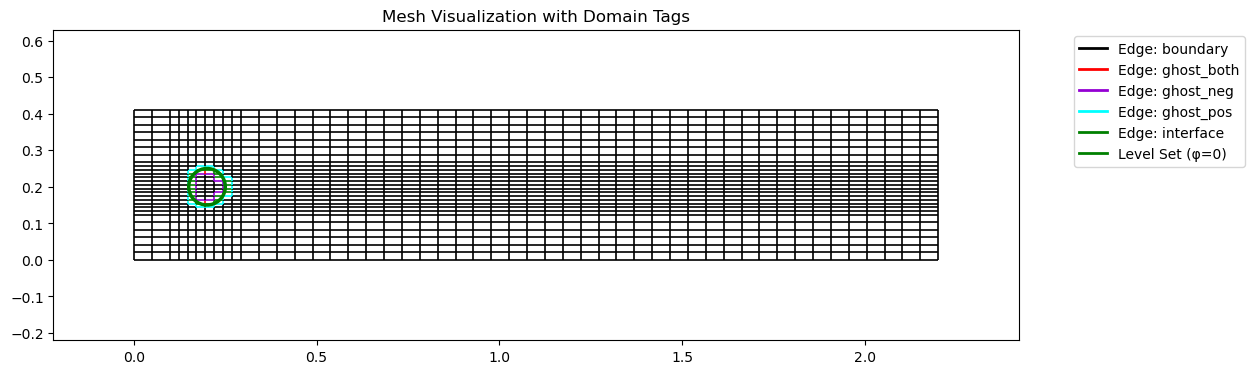

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [7]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [8]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_space = FunctionSpace(name="velocity", field_names=['ux', 'uy'],dim=1)
pressure_space = FunctionSpace(name="pressure", field_names=['p'], dim=0)

# Trial and Test functions
du = VectorTrialFunction(space=velocity_space, dof_handler=dof_handler)
dp = TrialFunction(name='trial_pressure', field_name='p', dof_handler=dof_handler)
v = VectorTestFunction(space=velocity_space, dof_handler=dof_handler)
q = TestFunction(name='test_pressure', field_name='p', dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.25)
theta = Constant(0.5) # Crank-Nicolson
mu_const = Constant(mu)
rho_const = Constant(rho)

u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_n' as separate contour plots...


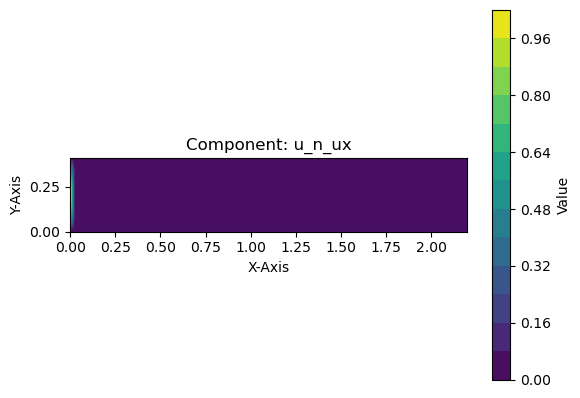

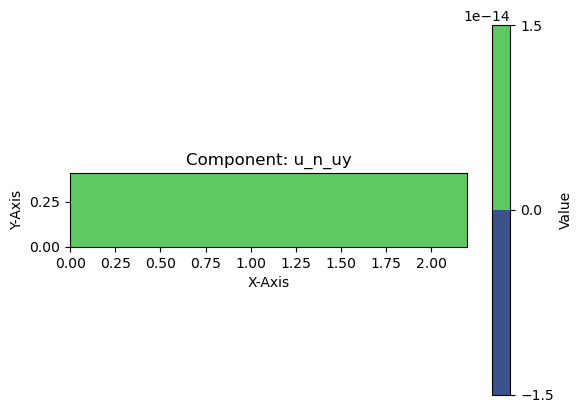

In [9]:
u_n.plot()

In [10]:
print(len(dof_handler.get_dirichlet_data(bcs)))

609


In [11]:
len(dof_handler.get_dirichlet_data(bcs))

609

In [12]:
from pycutfem.ufl.expressions import Derivative, FacetNormal, restrict
from pycutfem.core.geometry import hansbo_cut_ratio
from pycutfem.ufl.expressions import ElementWiseConstant

n = FacetNormal()                    # vector expression (n_x, n_y)
n_f = FacetNormal()                  # vector expression (n_x, n_y) on the fluid side

def _dn(expr):
    """Normal derivative  n·∇expr  on an (interior) edge."""
    Dx = Derivative(expr, 1, 0)
    Dy = Derivative(expr, 0, 1)
    _ = Dx + Dy
    return n[0]*Dx + n[1]*Dy

def grad_inner(u, v):
    """⟨∂ₙu, ∂ₙv⟩  (scalar or 2‑D vector)."""
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _dn(u) * _dn(v)

    if u.num_components == v.num_components == 2: # vector
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])

    raise ValueError("grad_inner supports only scalars or 2‑D vectors.")
ghost_edges_used = mesh.edge_bitset('ghost_pos') | mesh.edge_bitset('ghost_both') | mesh.edge_bitset('interface')
dx_phys  = dx(defined_on=physical_domain, 
              level_set=level_set,            # the cylinder level set
              metadata   = {"q": 7, "side": "+"} # integrate only φ>0 (positive side)
    )
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set, metadata={"q":9})   # interior surface
dG       = dGhost(defined_on=ghost_edges_used, level_set=level_set,metadata={"q":6,'derivs': {(0,1),(1,0)}})  # ghost surface

cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(100.0 * poly_order**2)      # Nitsche penalty (tweak)
# 1) Hansbo factor — this is a *numpy array*, one value per element
# beta0_val  = 10.0 * poly_order**2
# theta_min  = 1.0e-3
# hansbo_plus = hansbo_cut_ratio(mesh, level_set, side='+')    # -> np.ndarray, shape (n_elem,)
# beta_hansbo_arr = beta0_val / np.clip(hansbo_plus, theta_min, 1.0)

# Wrap only the array part in ElementWiseConstant
# β_h = ElementWiseConstant(beta_hansbo_arr)  # OK: per-element scalar

# 2) Symbolic augmentation factor (stays symbolic because of CellDiameter())
# augment = mu_const / cell_h + rho_const * cell_h / dt   # scalar expression

# 3) Final penalty (symbolic EWC × expression)
# β = β_h * augment

def epsilon(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)

# def sigma_dot_n(u_vec, p_scal):
#     """
#     Expanded form of (σ(u, p) · n) without using the '@' operator.

#         σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
#     """
#     # first term: μ (∇u)·n
#     a = dot(grad(u_vec), n)
#     # second term: μ (∇uᵀ)·n
#     b = dot(grad(u_vec).T, n)
#     # combine and subtract pressure part
#     return mu * (a + b) - p_scal * n         # vector of size 2

def sigma_dot_n_v(u_vec, p_scal,v_test,n):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return  mu * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du, dp, v,n_f)           # consistency
    - sigma_dot_n_v(v, q, du,n_f)           # symmetry
    + beta_N  / cell_h * dot(du, v)     # penalty
    # - dot(du,n) * q
    # + beta_N/ cell_h * dot(du,n) * dot(v,n)     # penalty
    # + β  * dot(du, v)     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(u_k, p_k, v,n_f)
    - sigma_dot_n_v(v, q, u_k,n_f)
    + beta_N  / cell_h * dot(u_k, v)
    # - dot(u_k,n) * q
    # + beta_N/ cell_h * dot(u_k,n) * dot(v,n)
    # + β  * dot(u_k, v)  
) * dΓ

# volume ------------------------------------------------------------
# a_vol = restrict(( rho*dot(du,v)/dt
#           + theta*rho*dot(dot(grad(u_k), du), v)
#           + theta*rho*dot(dot(grad(du), u_k), v)
#           + theta*mu*inner(grad(du), grad(v))
#           - dp*div(v) + q*div(du) ),physical_domain) * dx_phys

# r_vol = restrict(( rho*dot(u_k-u_n, v)/dt
#           + theta*rho*dot(dot(grad(u_k), u_k), v)
#           + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
#           + theta*mu*inner(grad(u_k), grad(v))
#           + (1-theta)*mu*inner(grad(u_n), grad(v))
#           - p_k*div(v) + q*div(u_k) ),physical_domain) * dx_phys
a_vol = ( rho*dot(du,v)/dt
          + theta*rho*dot(dot(grad(u_k), du), v)
          + theta*rho*dot(dot(grad(du), u_k), v)
          + 2 * theta*mu*inner(epsilon(du), epsilon(v))
          - dp*div(v) + q*div(du) ) * dx_phys

r_vol = ( rho*dot(u_k-u_n, v)/dt
          + theta*rho*dot(dot(grad(u_k), u_k), v)
          + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
          + 2 * theta*mu*inner(epsilon(u_k), epsilon(v))
          + 2 * (1-theta)*mu*inner(epsilon(u_n), epsilon(v))
          - p_k*div(v) + q*div(u_k) ) * dx_phys
          
# ghost stabilisation (add exactly as in your Poisson tests) --------
penalty_val = 0.001
penalty_grad = 0.05
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad= Constant(penalty_grad * poly_order**2)
gamma_p  = Constant(penalty_val * poly_order**1)
gamma_p_grad = Constant(penalty_grad * poly_order**1)

stab = ( gamma_v  / cell_h   * dot(jump(u_k), jump(v))
       + gamma_v_grad * cell_h   * grad_inner(jump(u_k), jump(v))
       + gamma_p  / cell_h   * jump(p_k) * jump(q)  # Note: use * for scalars, see issue 2
       + gamma_p_grad * cell_h   * grad_inner(jump(p_k), jump(q)) ) * dG

stab_lin  = (( gamma_v  / cell_h   * dot(jump(du),  jump(v)) +
             gamma_v_grad * cell_h   * grad_inner(jump(du),  jump(v))) 
           + ( gamma_p  / cell_h   * jump(dp) *  jump(q)
            + gamma_p_grad * cell_h   * grad_inner(jump(dp),  jump(q)))  ) * dG
# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol + J_int + stab_lin
residual_form  = r_vol + R_int + stab
# residual_form  = dot(  Constant(np.array([0.0, 0.0]),dim=1), v) * dx
# jacobian_form  = stab_lin
# residual_form  = stab





In [13]:
# !rm ~/.cache/pycutfem_jit/*

In [14]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [15]:
from pycutfem.io.vtk import export_vtk
from pycutfem.ufl.compilers import FormCompiler
from pycutfem.ufl.forms import Equation, assemble_form
from pycutfem.fem import transform
output_dir = "turek_results"
os.makedirs(output_dir, exist_ok=True)
step_counter = 0
histories = {}  # Store histories for CD, CL, Δp
# --- Traction helper on Γ: (σ(u,p)·n)·v_dir  -------------------------------
# Uses the same σ as in your Nitsche terms: μ(∇u + ∇uᵀ) - p I
def traction_dot_dir(u_vec, p_scal, v_dir):
    # n is provided by the interface/boundary assembler via FacetNormal()
    a = dot(grad(u_vec),   n)      # (∇u)·n
    b = dot(grad(u_vec).T, n)      # (∇uᵀ)·n
    t = mu*(a + b) - p_scal*n      # σ(u,p)·n   (vector in ℝ²)
    return dot(t, v_dir)           # scalar: (σ·n)·e_x or (σ·n)·e_y


def save_solution(funcs):
    """Export + compute CD, CL, Δp (Turek)."""
    global step_counter

    u_k_func = funcs[0]
    p_k_func = funcs[1]

    # ------------------ VTK output (as you already have) --------------------
    filename = os.path.join(output_dir, f"solution_{step_counter:04d}.vtu")
    export_vtk(
        filename=filename,
        mesh=mesh,
        dof_handler=dof_handler,
        functions={"velocity": u_k_func, "pressure": p_k_func}
    )

    # ------------------ Interface integrals for Drag & Lift -----------------
    # High-order quadrature helps here (Q2 velocity): use q≈11–13
    dΓ = dInterface(defined_on=cut_domain, level_set=level_set, metadata={"q": 11})

    e_x = Constant(np.array([1.0, 0.0]), dim =1)
    e_y = Constant(np.array([0.0, 1.0]), dim =1)

    # traction on the *fluid* side, then flip the sign to get the force on the cylinder
    integrand_drag = -traction_dot_dir(u_k_func, p_k_func, e_x)   # scalar
    integrand_lift = -traction_dot_dir(u_k_func, p_k_func, e_y)   # scalar

    I_drag = integrand_drag * dΓ
    I_lift = integrand_lift * dΓ

    # Assemble the two scalar functionals using the compiler “hooks”
    hooks = {
        I_drag.integrand: {"name": "FD"},
        I_lift.integrand: {"name": "FL"},
    }
    drag_hook = {I_drag.integrand: {"name": "FD"}}
    lift_hook = {I_lift.integrand: {"name": "FL"}}

    res_Fd = assemble_form(I_drag == Constant(0.0) * dx, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=drag_hook, backend="python")
    res_Fl = assemble_form(I_lift == Constant(0.0) * dx, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=lift_hook, backend="python")

    F_D = float(res_Fd["FD"])
    F_L = float(res_Fl["FL"])

    # Dimensionless coefficients (DFG definition)
    coeff = 2.0 / (rho * (U_mean**2) * D)
    C_D = coeff * F_D
    C_L = coeff * F_L

    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    def eval_scalar_at_point(f_scalar, x, y):
        """
        Robustly evaluates a scalar field at a point (x,y),
        ensuring the point is in the physical domain.
        """
        xy = np.array([x, y])

        # 1. First, check if the point is in the physical domain.
        if level_set(xy) < 0:
            # print(f"Warning: Point ({x},{y}) is in the fictitious domain (phi < 0). Returning NaN.")
            return np.nan

        # 2. Find the element that contains the point.
        eid_found = None
        for e in mesh.elements_list:
            # Skip elements that are fully inside the cylinder
            if getattr(e, "tag", None) == "inside":
                continue

            # Check if the point is geometrically within the element's bounding box first for efficiency
            v_coords = mesh.nodes_x_y_pos[list(e.corner_nodes)]
            if not (v_coords[:, 0].min() <= x <= v_coords[:, 0].max() and \
                    v_coords[:, 1].min() <= y <= v_coords[:, 1].max()):
                continue

            # Perform precise inverse mapping
            try:
                xi, eta = transform.inverse_mapping(mesh, e.id, xy)
                if -1e-9 <= xi <= 1 + 1e-9 and -1e-9 <= eta <= 1 + 1e-9:
                    eid_found = e.id
                    break
            except (np.linalg.LinAlgError, ValueError):
                continue # Point is outside this element.
        
        if eid_found is None:
            # print(f"Warning: Point ({x},{y}) could not be located in any physical element. Returning NaN.")
            return np.nan

        # 3. Evaluate the field using basis functions at the found reference coords.
        phi = mixed_element.basis(f_scalar.field_name, xi, eta)
        gdofs = dof_handler.get_elemental_dofs(eid_found)
        vals = f_scalar.get_nodal_values(gdofs)
        return float(phi @ vals)

    # Evaluate pressure slightly away from the cylinder boundary for stability.
    # Cylinder is at (0.2, 0.2) with radius 0.05.
    pA = eval_scalar_at_point(p_k_func, c_x - D/2 - 0.01, c_y) # Front point
    pB = eval_scalar_at_point(p_k_func, c_x + D/2 + 0.01, c_y) # Rear point
    dp = pA - pB

    # ------------------ Log / store ----------------------------------------
    print(f"[step {step_counter:4d}]  FD={F_D:.6e}  FL={F_L:.6e}  "
          f"CD={C_D:.6f}  CL={C_L:.6f}  Δp={dp:.6f}")
    if step_counter % 2 == 0:
        u_k_func.plot(field = 'ux',
                      title=f"Velocity Ux at step {step_counter}",
                      xlabel='X-Axis', ylabel='Y-Axis',
                      levels=100, cmap='jet',
                      mask = fluid_domain,)

    # (Optional) append to global histories for later plotting
    histories.setdefault("cd", []).append(C_D)
    histories.setdefault("cl", []).append(C_L)
    histories.setdefault("dp", []).append(dp)


    step_counter += 1



JIT cache miss → compiling _pycutfem_kernel_912e3c1cd969ab7843627ab78e775c5591f825ae7aaad72199116ddac6692bef.py
points shape: (42, 2), weights shape: (42,)
Found 28 valid cut elements for cut volume.
JIT cache miss → compiling _pycutfem_kernel_a988fdf40fd6bd042ec27e19e1c35b97ec8b89abe79ba24af62bb386f5c92759.py
JIT cache miss → compiling _pycutfem_kernel_be3560848234d5b9cd03bc3d78a34e49bb6b9529af646dbe4daa1c3144b5cc98.py
JIT cache miss → compiling _pycutfem_kernel_245cf465eff156a8578426451042187f3348bceb85385e6bd5a307870f2827da.py
Found 28 valid cut elements for cut volume.
JIT cache miss → compiling _pycutfem_kernel_2d623bee838e6a441e9a2ec45e9fb2e2a61622f3060f5fabe3d4b812d4d42741.py
JIT cache miss → compiling _pycutfem_kernel_f2164207cf63d9b9f4409292b40eb168ffdc79445e009ac4c2ceb93040f2ed7a.py
No Restriction operators found. All DOFs are considered active.
NewtonSolver: Reduced system with 11681/12290 DOFs.
  Dirichlet DOFs detected: 609; Free DOFs: 11681
        Newton 1: |R|_∞ = 1.43e

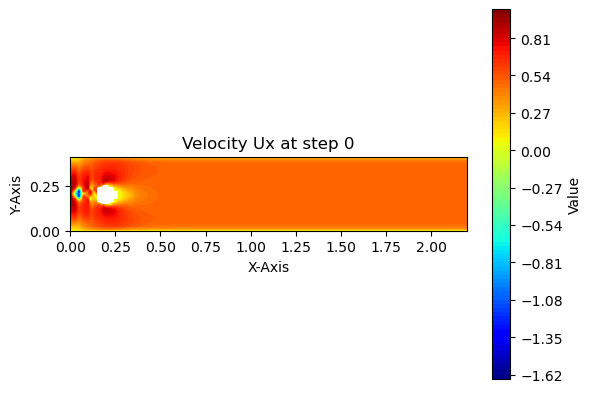

        Newton 1: |R|_∞ = 2.36e-02
        Armijo search accepted α = 5.00e-01
        Newton 2: |R|_∞ = 1.40e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.57e-02
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.78e-03
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 2.92e-03
        Armijo search accepted α = 1.00e+00
        Newton 6: |R|_∞ = 4.58e-04
        Armijo search accepted α = 1.00e+00
        Newton 7: |R|_∞ = 1.21e-05
        Armijo search accepted α = 1.00e+00
        Newton 8: |R|_∞ = 2.11e-08
    Time step 2: ΔU = 1.44e+03
Solution exported to turek_results/solution_0001.vtu
[step    1]  FD=-9.209599e-02  FL=-5.305628e-03  CD=-1.841920  CL=-0.106113  Δp=1.068813
        Newton 1: |R|_∞ = 2.79e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.02e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 9.54e-04
        Armijo search accepted α = 1.00e+00
  

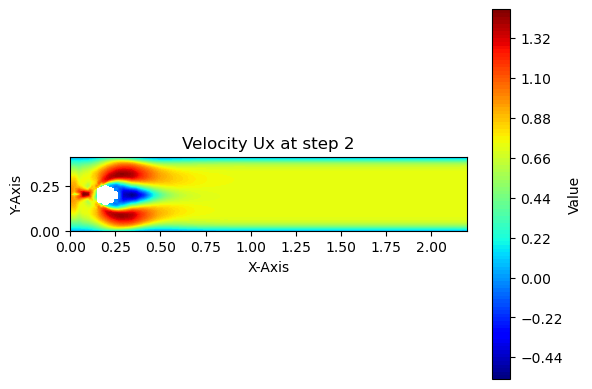

        Newton 1: |R|_∞ = 6.49e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.17e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.88e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 8.05e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 8.63e-09
    Time step 4: ΔU = 4.12e+02
Solution exported to turek_results/solution_0003.vtu
[step    3]  FD=-1.144013e-01  FL=4.054425e-03  CD=-2.288026  CL=0.081088  Δp=1.321915
        Newton 1: |R|_∞ = 2.29e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.49e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 7.10e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 3.43e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 9.02e-08
    Time step 5: ΔU = 4.47e+02
Solution exported to turek_results/solution_0004.vtu
[step    4]  FD=-8.494982e-02  FL=5.503627e

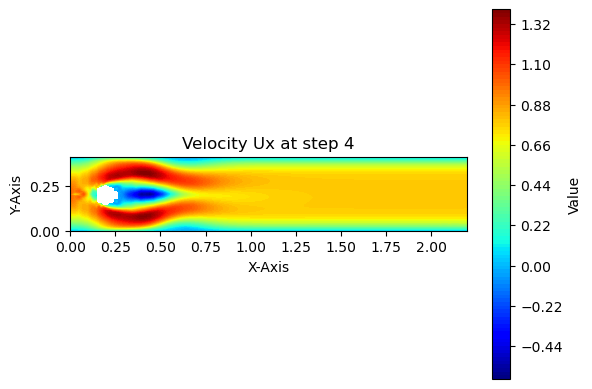

        Newton 1: |R|_∞ = 2.77e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 5.85e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.56e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 4.21e-08
    Time step 6: ΔU = 4.47e+02
Solution exported to turek_results/solution_0005.vtu
[step    5]  FD=-9.121510e-02  FL=-2.454154e-03  CD=-1.824302  CL=-0.049083  Δp=0.985278
        Newton 1: |R|_∞ = 2.02e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.28e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.58e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.68e-08
    Time step 7: ΔU = 4.37e+02
Solution exported to turek_results/solution_0006.vtu
[step    6]  FD=-9.254498e-02  FL=3.905542e-03  CD=-1.850900  CL=0.078111  Δp=1.058352
Plotting component: 'ux'


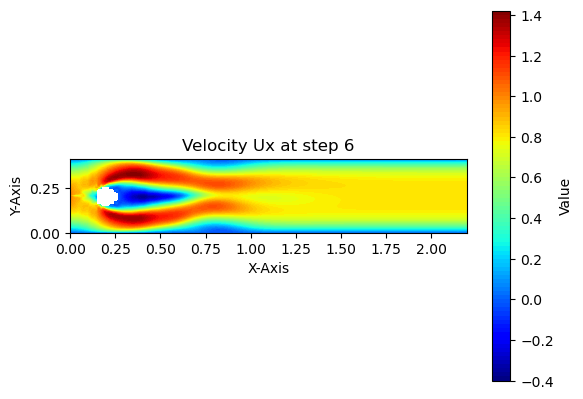

        Newton 1: |R|_∞ = 1.61e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.68e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.25e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.19e-08
    Time step 8: ΔU = 4.33e+02
Solution exported to turek_results/solution_0007.vtu
[step    7]  FD=-9.033032e-02  FL=2.420986e-03  CD=-1.806606  CL=0.048420  Δp=0.973882
        Newton 1: |R|_∞ = 1.21e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.19e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.46e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 4.29e-10
    Time step 9: ΔU = 4.28e+02
Solution exported to turek_results/solution_0008.vtu
[step    8]  FD=-9.145426e-02  FL=2.976778e-03  CD=-1.829085  CL=0.059536  Δp=1.016330
Plotting component: 'ux'


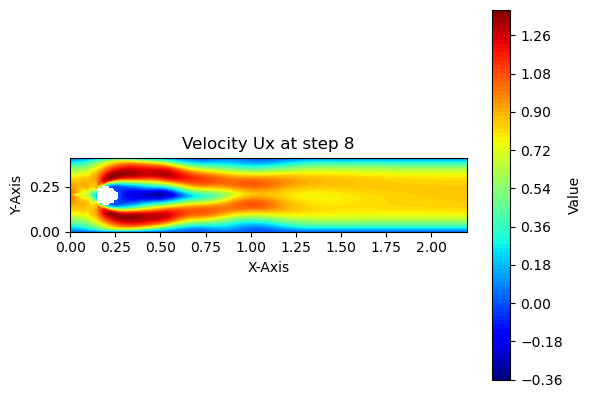

        Newton 1: |R|_∞ = 9.40e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.85e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.52e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 4.55e-10
    Time step 10: ΔU = 4.20e+02
Solution exported to turek_results/solution_0009.vtu
[step    9]  FD=-9.016291e-02  FL=-2.129382e-04  CD=-1.803258  CL=-0.004259  Δp=0.999156
        Newton 1: |R|_∞ = 1.08e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.68e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.31e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.28e-09
    Time step 11: ΔU = 4.19e+02
Solution exported to turek_results/solution_0010.vtu
[step   10]  FD=-9.132759e-02  FL=3.579416e-03  CD=-1.826552  CL=0.071588  Δp=0.995902
Plotting component: 'ux'


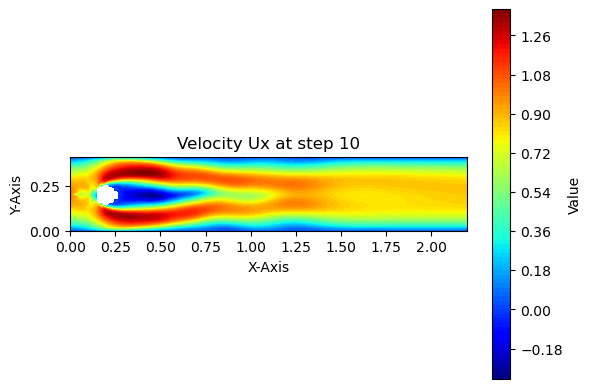

        Newton 1: |R|_∞ = 8.91e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.77e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.56e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.96e-09
    Time step 12: ΔU = 4.26e+02
Solution exported to turek_results/solution_0011.vtu
[step   11]  FD=-8.960266e-02  FL=2.045610e-03  CD=-1.792053  CL=0.040912  Δp=1.002949
        Newton 1: |R|_∞ = 1.08e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.63e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.56e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.97e-09
    Time step 13: ΔU = 4.36e+02
Solution exported to turek_results/solution_0012.vtu
[step   12]  FD=-9.159054e-02  FL=1.935270e-03  CD=-1.831811  CL=0.038705  Δp=0.992556
Plotting component: 'ux'


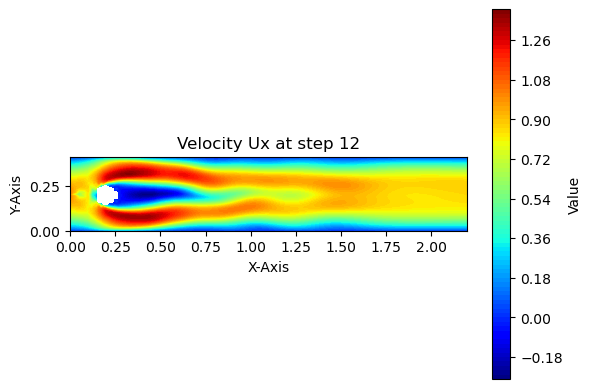

        Newton 1: |R|_∞ = 9.19e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.71e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 9.60e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.69e-08
    Time step 14: ΔU = 4.34e+02
Solution exported to turek_results/solution_0013.vtu
[step   13]  FD=-8.947041e-02  FL=2.022928e-05  CD=-1.789408  CL=0.000405  Δp=1.001436
        Newton 1: |R|_∞ = 1.13e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.53e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.86e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 3.69e-08
    Time step 15: ΔU = 4.25e+02
Solution exported to turek_results/solution_0014.vtu
[step   14]  FD=-9.142262e-02  FL=5.204715e-03  CD=-1.828452  CL=0.104094  Δp=0.993069
Plotting component: 'ux'


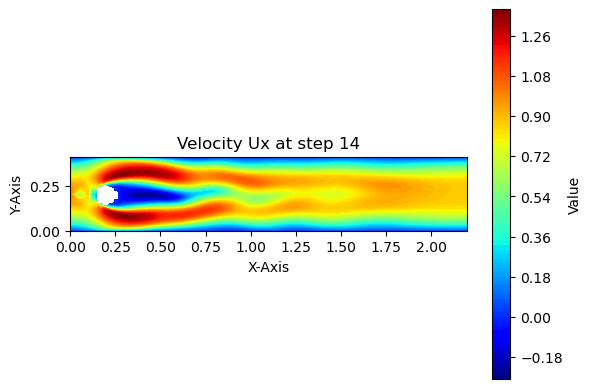

        Newton 1: |R|_∞ = 1.05e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.89e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.39e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.17e-08
    Time step 16: ΔU = 4.22e+02
Solution exported to turek_results/solution_0015.vtu
[step   15]  FD=-8.997283e-02  FL=7.223858e-04  CD=-1.799457  CL=0.014448  Δp=0.999451
        Newton 1: |R|_∞ = 1.14e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 5.15e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.15e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.56e-07
    Time step 17: ΔU = 4.34e+02
Solution exported to turek_results/solution_0016.vtu
[step   16]  FD=-9.037598e-02  FL=1.071149e-03  CD=-1.807520  CL=0.021423  Δp=0.991796
Plotting component: 'ux'


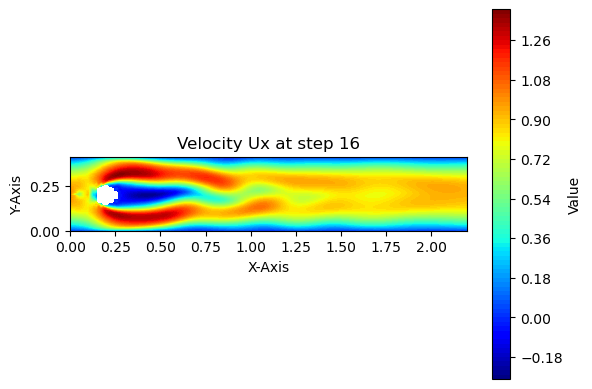

        Newton 1: |R|_∞ = 1.09e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 5.06e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.44e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.04e-07
    Time step 18: ΔU = 4.39e+02
Solution exported to turek_results/solution_0017.vtu
[step   17]  FD=-9.032720e-02  FL=2.130898e-03  CD=-1.806544  CL=0.042618  Δp=0.995128
        Newton 1: |R|_∞ = 1.24e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 6.37e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 5.91e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 4.36e-07
    Time step 19: ΔU = 4.31e+02
Solution exported to turek_results/solution_0018.vtu
[step   18]  FD=-8.975036e-02  FL=4.777431e-03  CD=-1.795007  CL=0.095549  Δp=0.990957
Plotting component: 'ux'


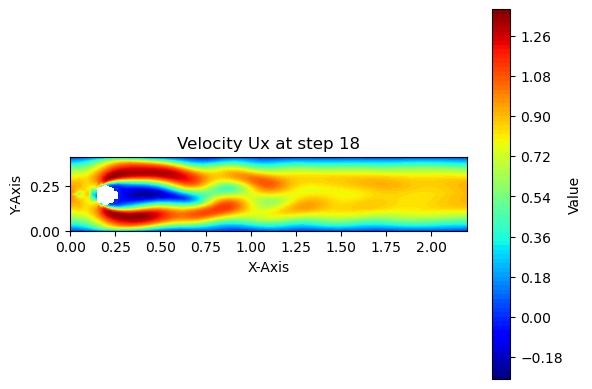

        Newton 1: |R|_∞ = 1.25e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 7.14e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 9.06e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.99e-07
    Time step 20: ΔU = 4.17e+02
Solution exported to turek_results/solution_0019.vtu
[step   19]  FD=-9.053497e-02  FL=-1.367047e-03  CD=-1.810699  CL=-0.027341  Δp=0.992380
        Newton 1: |R|_∞ = 1.41e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.64e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 7.37e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.63e-07
    Time step 21: ΔU = 4.14e+02
Solution exported to turek_results/solution_0020.vtu
[step   20]  FD=-8.960521e-02  FL=1.896070e-03  CD=-1.792104  CL=0.037921  Δp=0.993727
Plotting component: 'ux'


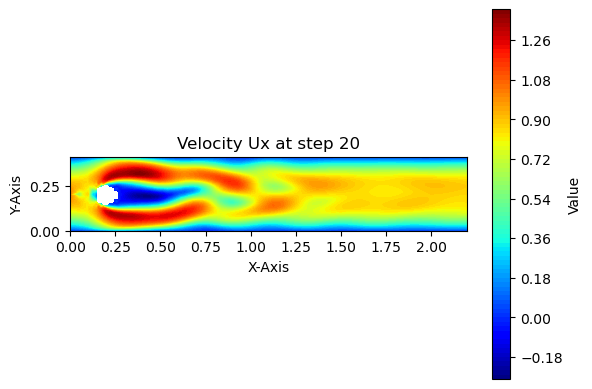

        Newton 1: |R|_∞ = 1.45e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 9.09e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.07e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.05e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.81e-10
    Time step 22: ΔU = 4.31e+02
Solution exported to turek_results/solution_0021.vtu
[step   21]  FD=-9.119604e-02  FL=4.562878e-03  CD=-1.823921  CL=0.091258  Δp=0.995132
        Newton 1: |R|_∞ = 1.42e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.77e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 9.65e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.72e-07
    Time step 23: ΔU = 4.38e+02
Solution exported to turek_results/solution_0022.vtu
[step   22]  FD=-8.981867e-02  FL=1.964864e-03  CD=-1.796373  CL=0.039297  Δp=0.995820
Plotting component: 'ux'


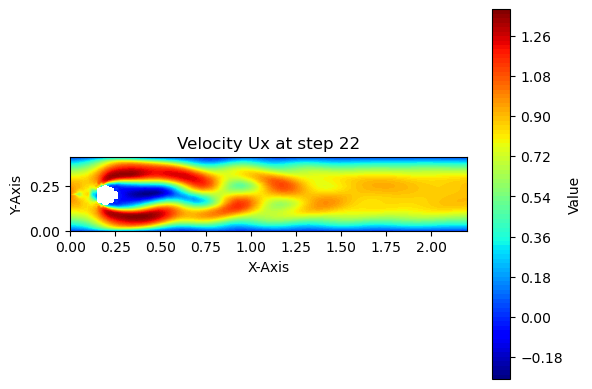

        Newton 1: |R|_∞ = 1.57e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.12e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.26e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.30e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 7.30e-10
    Time step 24: ΔU = 4.21e+02
Solution exported to turek_results/solution_0023.vtu
[step   23]  FD=-9.075989e-02  FL=-1.983809e-03  CD=-1.815198  CL=-0.039676  Δp=0.993651
        Newton 1: |R|_∞ = 1.64e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.12e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.61e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.11e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.18e-09
    Time step 25: ΔU = 4.02e+02
Solution exported to turek_results/solution_0024.vtu
[step   24]  FD=-9.016876e-02  FL=5.403

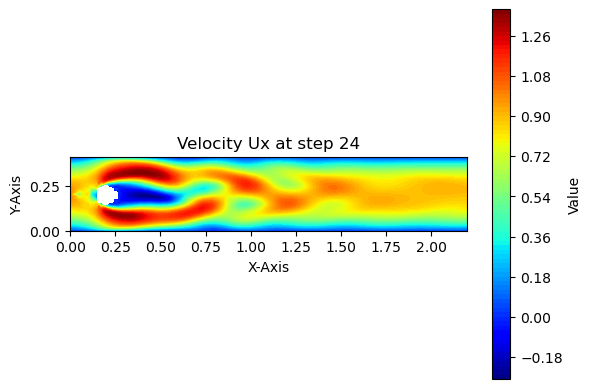

        Newton 1: |R|_∞ = 1.74e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.06e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.18e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.54e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.81e-10
    Time step 26: ΔU = 4.11e+02
Solution exported to turek_results/solution_0025.vtu
[step   25]  FD=-9.098166e-02  FL=3.717511e-03  CD=-1.819633  CL=0.074350  Δp=0.995587
        Newton 1: |R|_∞ = 1.72e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.34e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.37e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.08e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.61e-09
    Time step 27: ΔU = 4.35e+02
Solution exported to turek_results/solution_0026.vtu
[step   26]  FD=-9.015287e-02  FL=-1.9077

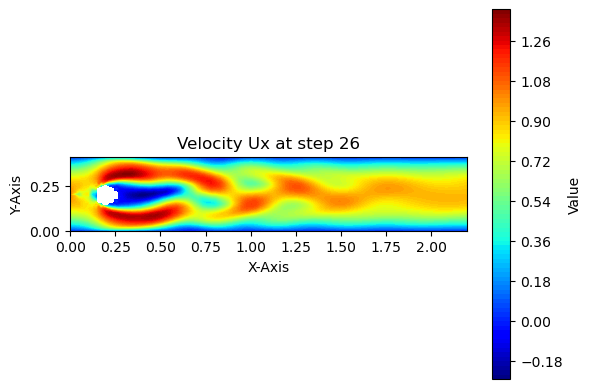

        Newton 1: |R|_∞ = 1.75e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.12e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.72e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.52e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.76e-09
    Time step 28: ΔU = 4.38e+02
Solution exported to turek_results/solution_0027.vtu
[step   27]  FD=-9.071756e-02  FL=1.212673e-03  CD=-1.814351  CL=0.024253  Δp=0.996623
        Newton 1: |R|_∞ = 1.98e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.29e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.92e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 3.13e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.03e-09
    Time step 29: ΔU = 4.12e+02
Solution exported to turek_results/solution_0028.vtu
[step   28]  FD=-9.076558e-02  FL=7.64083

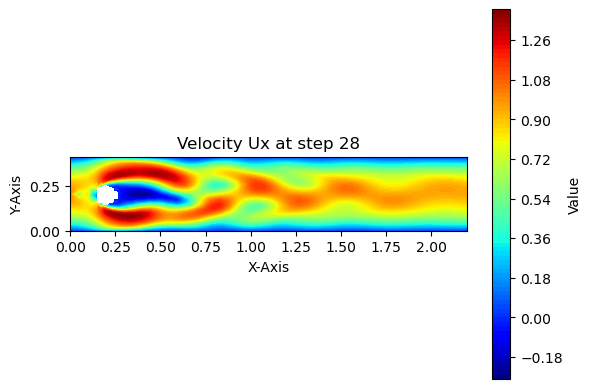

        Newton 1: |R|_∞ = 1.89e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.44e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.22e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.34e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 8.46e-09
    Time step 30: ΔU = 3.93e+02
Solution exported to turek_results/solution_0029.vtu
[step   29]  FD=-9.064913e-02  FL=-1.143221e-03  CD=-1.812983  CL=-0.022864  Δp=0.997530
        Newton 1: |R|_∞ = 1.89e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.41e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.49e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.40e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 9.89e-10
    Time step 31: ΔU = 4.11e+02
Solution exported to turek_results/solution_0030.vtu
[step   30]  FD=-9.044562e-02  FL=-1.69

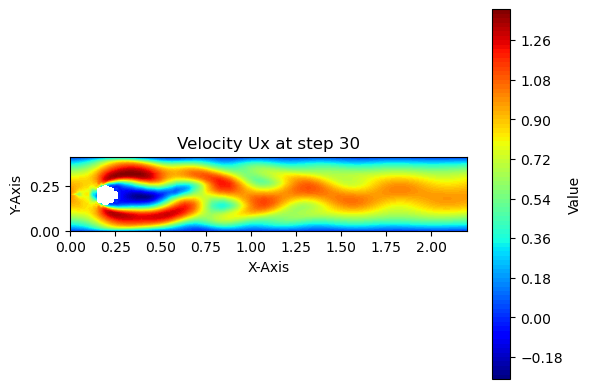

        Newton 1: |R|_∞ = 2.12e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.62e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.89e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.67e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 8.98e-09
    Time step 32: ΔU = 4.41e+02
Solution exported to turek_results/solution_0031.vtu
[step   31]  FD=-9.103605e-02  FL=6.830755e-03  CD=-1.820721  CL=0.136615  Δp=1.000482
        Newton 1: |R|_∞ = 2.09e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.34e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.78e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.10e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 4.49e-09
    Time step 33: ΔU = 4.37e+02
Solution exported to turek_results/solution_0032.vtu
[step   32]  FD=-9.087466e-02  FL=4.31852

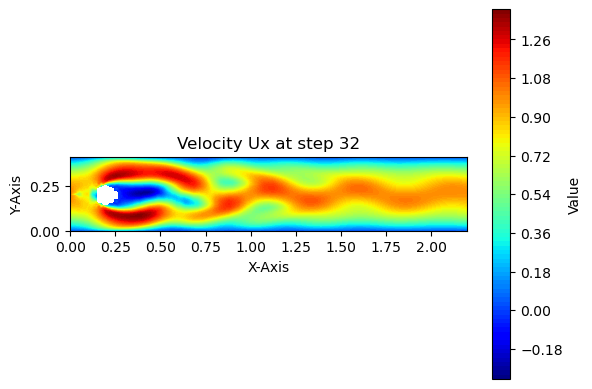

        Newton 1: |R|_∞ = 1.98e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.69e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.54e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 8.39e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.13e-08
    Time step 34: ΔU = 4.00e+02
Solution exported to turek_results/solution_0033.vtu
[step   33]  FD=-9.057290e-02  FL=-5.271205e-03  CD=-1.811458  CL=-0.105424  Δp=0.999331
        Newton 1: |R|_∞ = 2.30e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.78e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.74e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 9.99e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.32e-08
    Time step 35: ΔU = 3.83e+02
Solution exported to turek_results/solution_0034.vtu
[step   34]  FD=-9.093142e-02  FL=4.151

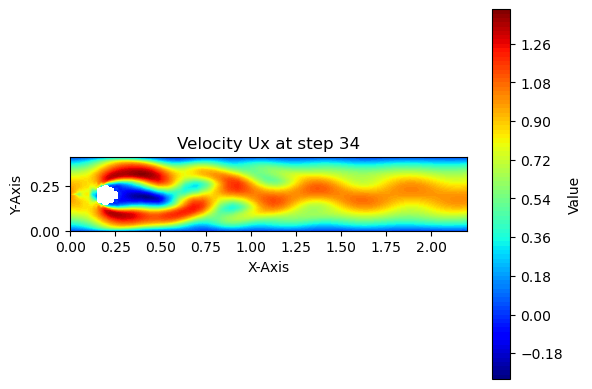

        Newton 1: |R|_∞ = 2.26e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.38e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.37e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 3.29e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.96e-09
    Time step 36: ΔU = 4.13e+02
Solution exported to turek_results/solution_0035.vtu
[step   35]  FD=-9.129522e-02  FL=7.927953e-03  CD=-1.825904  CL=0.158559  Δp=1.001602
        Newton 1: |R|_∞ = 2.26e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.92e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.51e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.48e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 6.13e-08
    Time step 37: ΔU = 4.48e+02
Solution exported to turek_results/solution_0036.vtu
[step   36]  FD=-9.079761e-02  FL=-3.0139

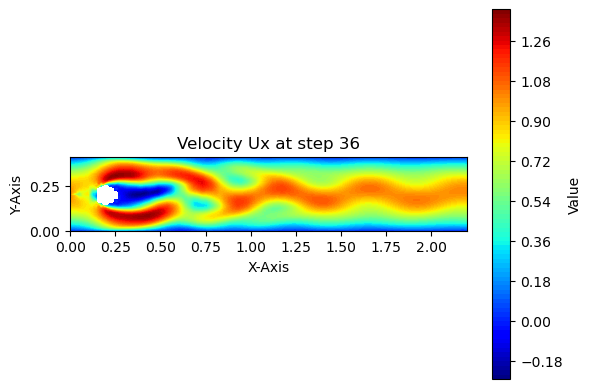

        Newton 1: |R|_∞ = 2.19e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.59e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.22e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.19e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 2.10e-08
    Time step 38: ΔU = 4.32e+02
Solution exported to turek_results/solution_0037.vtu
[step   37]  FD=-9.089966e-02  FL=-2.414114e-03  CD=-1.817993  CL=-0.048282  Δp=1.001479
        Newton 1: |R|_∞ = 2.41e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.73e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.79e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.30e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 4.62e-09
    Time step 39: ΔU = 3.86e+02
Solution exported to turek_results/solution_0038.vtu
[step   38]  FD=-9.145764e-02  FL=1.045

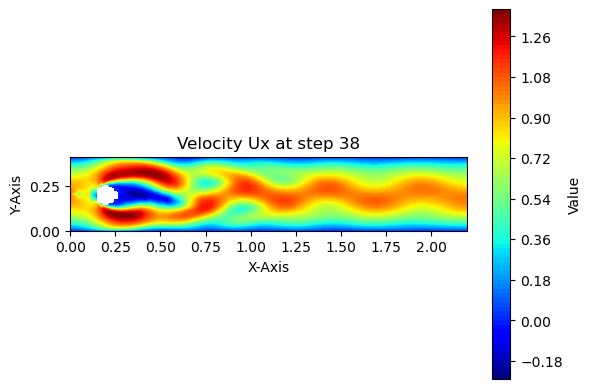

        Newton 1: |R|_∞ = 2.52e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.01e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 5.50e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.89e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 7.12e-08
    Time step 40: ΔU = 3.77e+02
Solution exported to turek_results/solution_0039.vtu
[step   39]  FD=-9.133136e-02  FL=1.738687e-03  CD=-1.826627  CL=0.034774  Δp=1.003816
        Newton 1: |R|_∞ = 2.11e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.74e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.16e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.27e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.25e-09
    Time step 41: ΔU = 4.20e+02
Solution exported to turek_results/solution_0040.vtu
[step   40]  FD=-9.075118e-02  FL=-6.0374

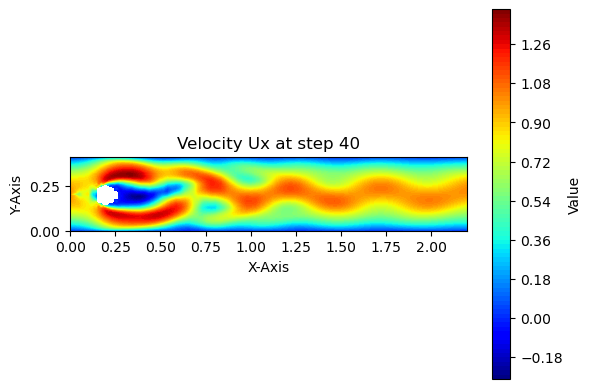

        Newton 1: |R|_∞ = 2.59e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.04e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.73e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.44e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 4.15e-08
    Time step 42: ΔU = 4.52e+02
Solution exported to turek_results/solution_0041.vtu
[step   41]  FD=-9.165857e-02  FL=6.212419e-03  CD=-1.833171  CL=0.124248  Δp=1.007618
        Newton 1: |R|_∞ = 2.44e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.70e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.92e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.31e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 2.53e-08
    Time step 43: ΔU = 4.23e+02
Solution exported to turek_results/solution_0042.vtu
[step   42]  FD=-9.154504e-02  FL=8.90960

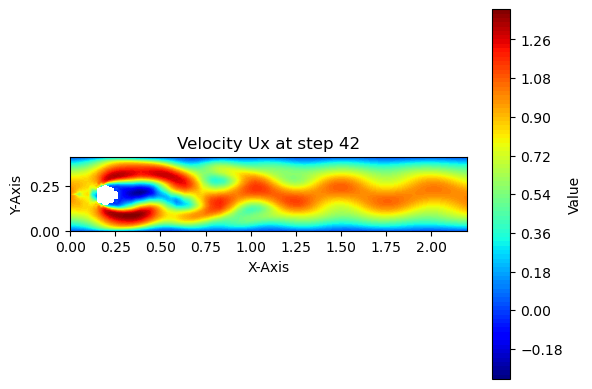

        Newton 1: |R|_∞ = 2.40e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.07e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.63e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.48e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 5.29e-08
    Time step 44: ΔU = 3.71e+02
Solution exported to turek_results/solution_0043.vtu
[step   43]  FD=-9.127906e-02  FL=-6.691254e-03  CD=-1.825581  CL=-0.133825  Δp=1.007371
        Newton 1: |R|_∞ = 2.54e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.97e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 5.11e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.09e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 8.89e-08
    Time step 45: ΔU = 3.75e+02
Solution exported to turek_results/solution_0044.vtu
[step   44]  FD=-9.120920e-02  FL=-3.10

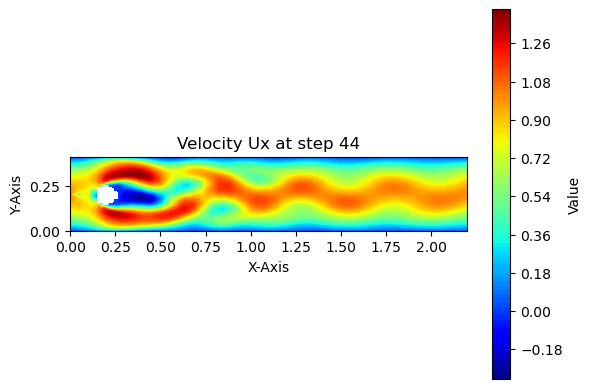

        Newton 1: |R|_∞ = 2.52e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.60e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.49e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 4.99e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.91e-09
    Time step 46: ΔU = 4.30e+02
Solution exported to turek_results/solution_0045.vtu
[step   45]  FD=-9.214343e-02  FL=1.169605e-02  CD=-1.842869  CL=0.233921  Δp=1.009968
        Newton 1: |R|_∞ = 2.71e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.35e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.50e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.70e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 2.42e-07
    Time step 47: ΔU = 4.54e+02
Solution exported to turek_results/solution_0046.vtu
[step   46]  FD=-9.146308e-02  FL=-1.3036

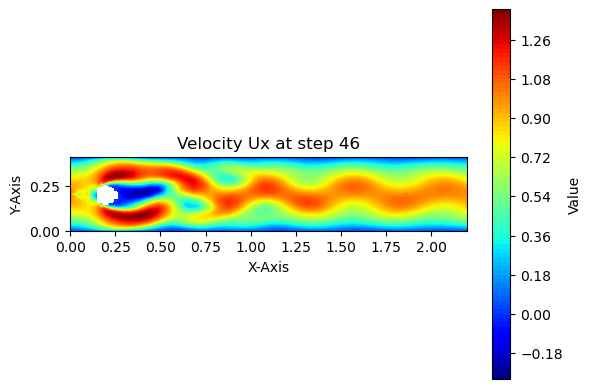

        Newton 1: |R|_∞ = 2.14e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.68e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.62e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.35e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 4.90e-08
    Time step 48: ΔU = 4.09e+02
Solution exported to turek_results/solution_0047.vtu
[step   47]  FD=-9.130682e-02  FL=-7.182154e-03  CD=-1.826136  CL=-0.143643  Δp=1.006800
        Newton 1: |R|_∞ = 2.65e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.95e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 5.59e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.69e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.92e-08
    Time step 49: ΔU = 3.59e+02
Solution exported to turek_results/solution_0048.vtu
[step   48]  FD=-9.200512e-02  FL=9.898

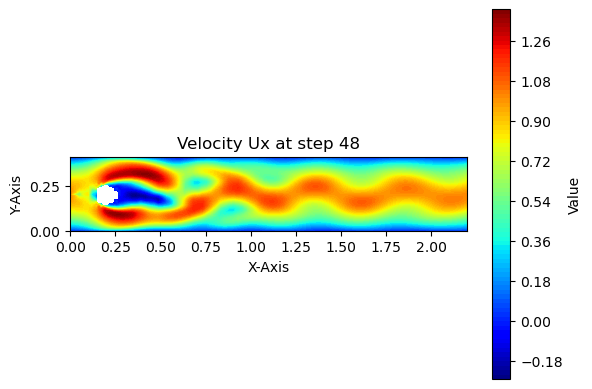

        Newton 1: |R|_∞ = 2.70e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.20e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.28e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.45e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 1.76e-07
    Time step 50: ΔU = 3.79e+02
Solution exported to turek_results/solution_0049.vtu
[step   49]  FD=-9.212382e-02  FL=7.406106e-03  CD=-1.842476  CL=0.148122  Δp=1.009475


(array([ 0.        ,  0.        ,  0.        , ...,  0.00424739,
        -0.00151674, -0.00015617]),
 50,
 1790.488862505008)

In [16]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters, AdamNewtonSolver
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")


# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=50 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
    postproc_timeloop_cb=save_solution
)
# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

Text(0, 0.5, 'Δp')

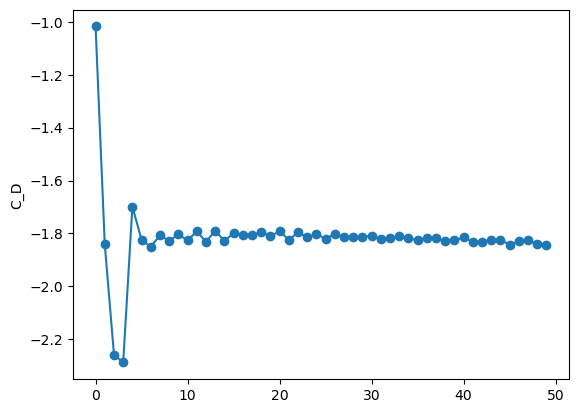

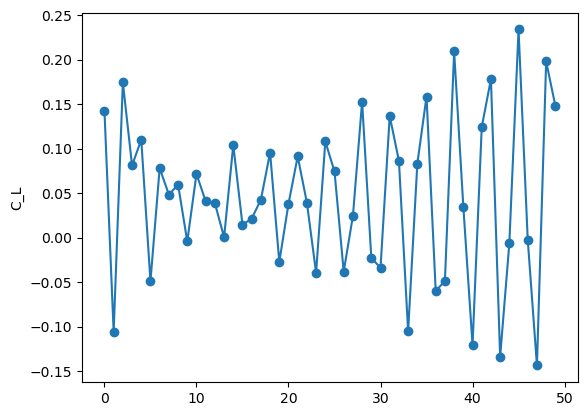

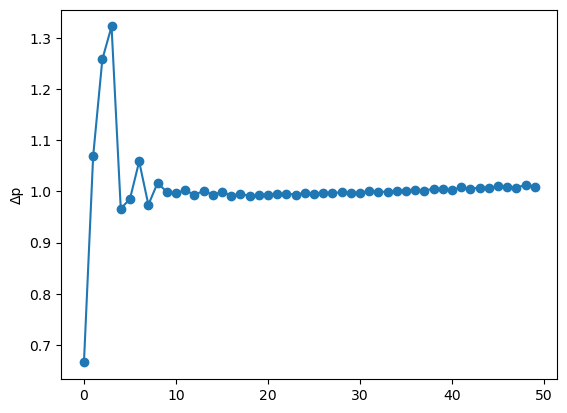

In [17]:
plt.plot(histories["cd"], label="C_D", marker='o')
plt.ylabel('C_D')
plt.figure()
plt.plot(histories["cl"], label="C_L", marker='o')
plt.ylabel('C_L')
plt.figure()
plt.plot(histories["dp"], label="Δp", marker='o')
plt.ylabel('Δp')

Plotting all components of 'u_n' as separate contour plots...


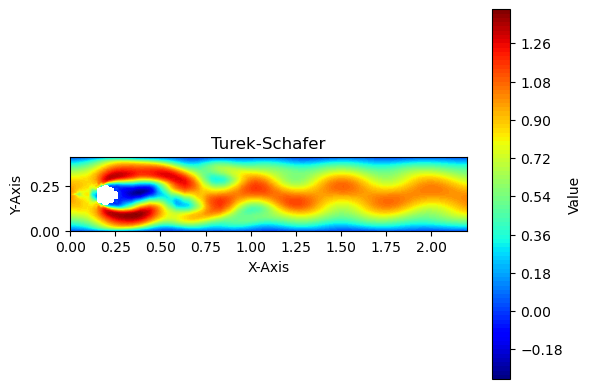

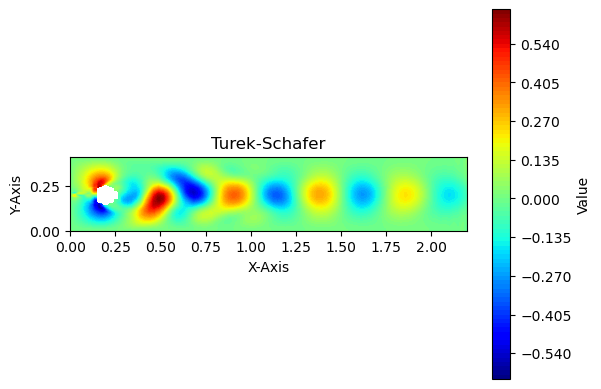

In [18]:


u_n.plot(kind="contour",mask =fluid_domain,
         title="Turek-Schafer",
         xlabel='X-Axis', ylabel='Y-Axis',
         levels=100, cmap='jet')

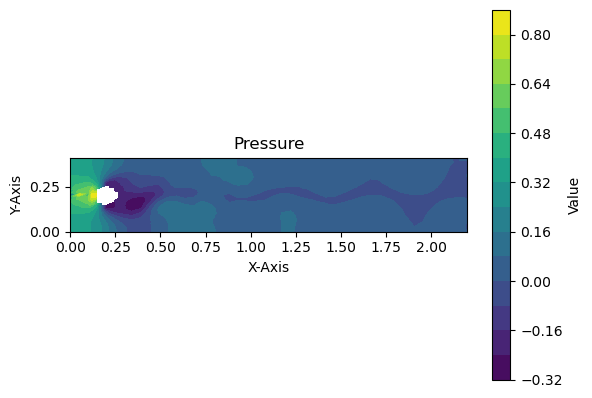

In [19]:
p_n.plot(
         title="Pressure",mask =fluid_domain)